In [7]:
!pip install tensorflow
!pip install pandas_ta

  Using cached pandas_ta-0.3.14b.tar.gz (115 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for pandas_ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218923 sha256=4350c476d3905a09baa81c2586fc614f30e8a31aa1d01ddff6b2d1dc3dd5bf01
  Stored in directory: c:\users\chris\appdata\local\pip\cache\wheels\7f\33\8b\50b245c5c65433cd8f5cb24ac15d97e5a3db2d41a8b6ae957d
Successfully built pandas_ta


In [10]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from statsmodels.tsa.api import VAR
import os
from dotenv import load_dotenv
import yfinance as yf
import pandas as pd
import pandas_ta as ta
from alpha_vantage.timeseries import TimeSeries
# Load environment variables from the .env file
load_dotenv('../.env');

# Data Viz. 
import statsmodels.formula.api as smf
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.ndimage import gaussian_filter
from calendar import monthrange
from calendar import month_name

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns

In [11]:
# Specify the stock symbol and the date range
stock_symbol = "AAPL"
start_date = "2013-01-01"
end_date = "2023-12-18"

# Fetch the stock data
apple_cl = yf.download(stock_symbol, start=start_date, end=end_date)

# Display the stock data
apple_cl.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2013-01-02,19.779285,19.821428,19.343929,19.608213,16.769091,560518000
2013-01-03,19.567142,19.631071,19.321428,19.360714,16.557430,352965200
2013-01-04,19.177500,19.236786,18.779642,18.821428,16.096230,594333600
2013-01-07,18.642857,18.903570,18.400000,18.710714,16.001545,484156400
2013-01-08,18.900356,18.996071,18.616072,18.761070,16.044605,458707200


In [12]:
#here we are adding technical indicators to the data set as seperate columns

apple_cl['RSI'] = ta.rsi(apple_cl.Close, length=15)
apple_cl['EMAF'] = ta.ema(apple_cl.Close, length=20) #fast moving avg
apple_cl['EMAM'] = ta.ema(apple_cl.Close, length=100) #medium moving avg
apple_cl['EMAS'] = ta.ema(apple_cl.Close, length=150) #slow moving avg


apple_cl['target'] = apple_cl['Adj Close'] - apple_cl.Open
apple_cl['target'] = apple_cl['target'].shift(-1)
apple_cl['target_class'] = [1 if apple_cl.target[i]>0 else 0 for i in range(len(apple_cl))]
apple_cl['target_next_close'] = apple_cl['Adj Close'].shift(-1)

apple_cl.dropna(inplace=True)
apple_cl.reset_index(inplace=True)
apple_cl.drop(['Volume' , 'Close', 'Date'], axis=1, inplace=True)


C:\Users\chris\AppData\Local\Temp\ipykernel_38644\692162287.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  apple_cl['target_class'] = [1 if apple_cl.target[i]>0 else 0 for i in range(len(apple_cl))]


In [13]:
apple_cl = apple_cl.iloc[:, 0:11] 

In [14]:
apple_cl.head()

,Open,High,Low,Adj Close,RSI,EMAF,EMAM,EMAS,target,target_class,target_next_close
0,16.715000,16.853214,16.506071,14.387613,69.038240,15.848586,15.722364,15.912712,-2.185020,0,14.379265
1,16.564285,16.678572,16.491785,14.379265,68.764895,15.920761,15.739870,15.921900,-2.215803,0,14.350626
2,16.566429,16.575001,16.355356,14.350626,64.727822,15.972559,15.754222,15.929089,-2.233572,0,14.146427
3,16.379999,16.445000,16.201786,14.146427,58.633462,15.997112,15.763650,15.933079,-1.768133,0,14.548296
4,16.316429,16.737499,16.308214,14.548296,65.485540,16.063237,15.782022,15.943124,-1.579628,0,15.239658


In [15]:
# Stock closing prices are features and date is the date time index

numeric_features = apple_cl[['Open', 'High', 'Low', 'Adj Close', 'RSI', 'EMAF', 'EMAS', 'EMAM']]
targets = apple_cl[['target', 'target_class', 'target_next_close']]

train_size = int(len(apple_cl) * 0.8)
train_features, test_features = numeric_features[:train_size], numeric_features[train_size:]
train_targets, test_targets = targets[:train_size], targets[train_size:]


# Create a preprocessing pipeline
preprocessing_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', MinMaxScaler(feature_range=(0,1)))
])

# Apply the preprocessing pipeline to numeric features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', preprocessing_pipeline, numeric_features.columns)
    ])

In [16]:
# Fit and transform the training data
train_features_preprocessed = preprocessor.fit_transform(train_features)

# Transform the test data using the learned parameters from the training data
test_features_preprocessed = preprocessor.transform(test_features)

### Reshape the Data

In [17]:
def reshape_for_lstm(data, time_steps):
    return data.reshape((data.shape[0], time_steps, data.shape[1]))

time_steps = 1  # You can experiment with different time steps
train_features_lstm = reshape_for_lstm(train_features_preprocessed, time_steps)
test_features_lstm = reshape_for_lstm(test_features_preprocessed, time_steps)


### Build The Model

In [18]:
model = Sequential()
time_steps = 1
model.add(LSTM(units=50, activation='relu', input_shape=(time_steps, numeric_features.shape[1])))
model.add(Dense(units=3))  # Assuming you have 3 output columns

model.compile(optimizer='adam', loss='mean_squared_error')  # Adjust the loss function based on your problem

In [19]:
### Train the model

In [38]:
epochs = 50
batch_size = 32

In [39]:
model.fit(train_features_lstm, train_targets, epochs=epochs, batch_size=batch_size)


Epoch 1/50
66/66 [==============================] - 0s 2ms/step - loss: 0.8080
Epoch 2/50
66/66 [==============================] - 0s 2ms/step - loss: 0.8112
Epoch 3/50
66/66 [==============================] - 0s 2ms/step - loss: 0.8046
Epoch 4/50
66/66 [==============================] - 0s 2ms/step - loss: 0.8210
Epoch 5/50
66/66 [==============================] - 0s 2ms/step - loss: 0.8187
Epoch 6/50
66/66 [==============================] - 0s 2ms/step - loss: 0.8136
Epoch 7/50
66/66 [==============================] - 0s 2ms/step - loss: 0.8024
Epoch 8/50
66/66 [==============================] - 0s 2ms/step - loss: 0.8143
Epoch 9/50
66/66 [==============================] - 0s 2ms/step - loss: 0.8093
Epoch 10/50
66/66 [==============================] - 0s 2ms/step - loss: 0.8041
Epoch 11/50
66/66 [==============================] - 0s 2ms/step - loss: 0.8026
Epoch 12/50
66/66 [==============================] - 0s 2ms/step - loss: 0.8088
Epoch 13/50
66/66 [==============================

In [40]:
test_loss = model.evaluate(test_features_lstm, test_targets)
print(f'Test Loss: {test_loss}')

17/17 [==============================] - 0s 1ms/step - loss: 6.6588
Test Loss: 6.658849716186523


17/17 [==============================] - 0s 2ms/step


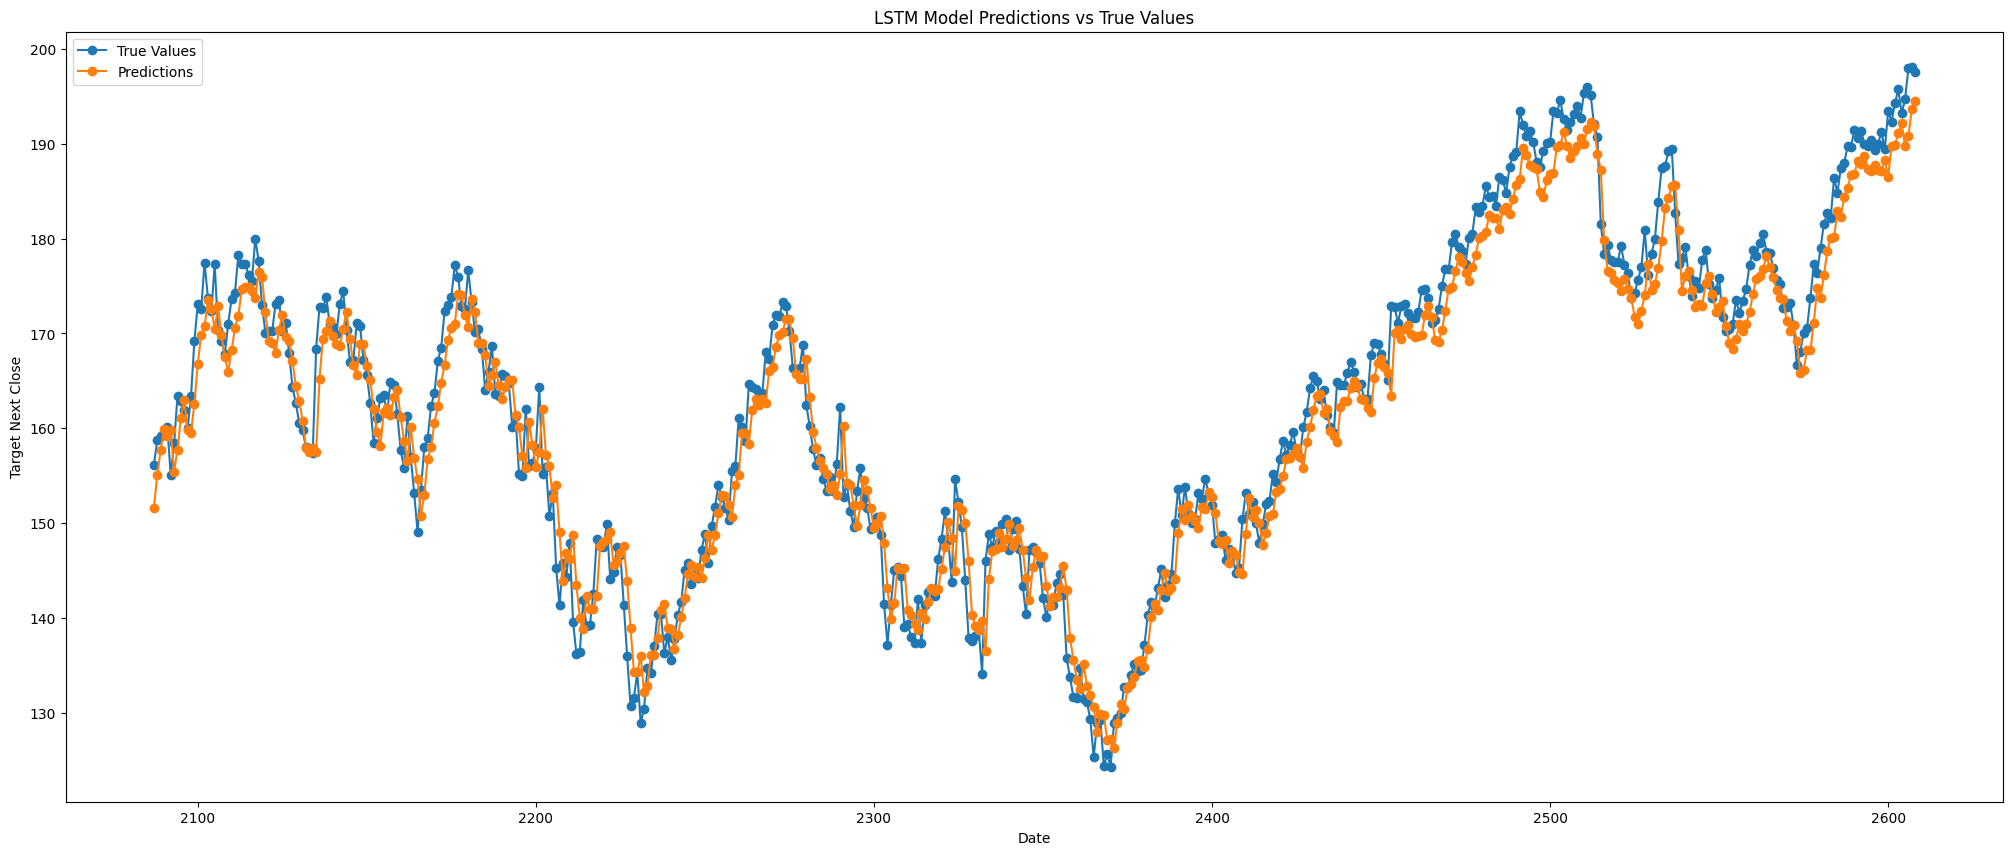

In [41]:
import matplotlib.pyplot as plt

# Assuming 'model' is your trained LSTM model
predictions = model.predict(test_features_lstm)

# Plotting
plt.figure(figsize=(25, 10))
plt.plot(test_targets.index, test_targets['target_next_close'], label='True Values', marker='o')
plt.plot(test_targets.index, predictions[:, 2], label='Predictions', marker='o')  # Assuming 'target_next_close' is the third column
plt.title('LSTM Model Predictions vs True Values')
plt.xlabel('Date')
plt.ylabel('Target Next Close')
plt.legend()
plt.show()


Epoch 1/50
66/66 [==============================] - 0s 3ms/step - loss: 0.8062 - val_loss: 7.0090
Epoch 2/50
66/66 [==============================] - 0s 2ms/step - loss: 0.8144 - val_loss: 7.3661
Epoch 3/50
66/66 [==============================] - 0s 2ms/step - loss: 0.8068 - val_loss: 7.0528
Epoch 4/50
66/66 [==============================] - 0s 2ms/step - loss: 0.8068 - val_loss: 6.5222
Epoch 5/50
66/66 [==============================] - 0s 2ms/step - loss: 0.8054 - val_loss: 6.6591
Epoch 6/50
66/66 [==============================] - 0s 2ms/step - loss: 0.8013 - val_loss: 7.1372
Epoch 7/50
66/66 [==============================] - 0s 2ms/step - loss: 0.8009 - val_loss: 7.3127
Epoch 8/50
66/66 [==============================] - 0s 2ms/step - loss: 0.8164 - val_loss: 7.3312
Epoch 9/50
66/66 [==============================] - 0s 2ms/step - loss: 0.8036 - val_loss: 7.0393
Epoch 10/50
66/66 [==============================] - 0s 2ms/step - loss: 0.8020 - val_loss: 7.2689
Epoch 11/50
66/66 [

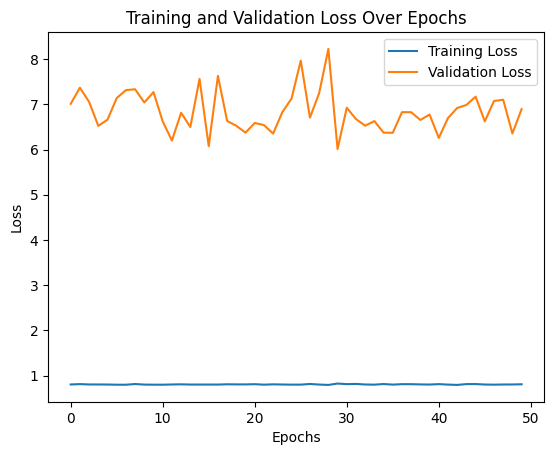

In [42]:
history = model.fit(train_features_lstm, train_targets, epochs=epochs, batch_size=batch_size, validation_data=(test_features_lstm, test_targets))

# Plot training loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [43]:
### what dis mean??


In [46]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

predictions = model.predict(test_features_lstm)
mae = mean_absolute_error(test_targets['target_next_close'], predictions[:, 2])  # Assuming 'target_next_close' is the third column
mse = mean_squared_error(test_targets['target_next_close'], predictions[:, 2])
rmse = np.sqrt(mse)

print(f'MAE: {mae:.2f}')
print(f'MSE: {mse:.2f}')
print(f'RMSE: {rmse:.2f}')

17/17 [==============================] - 0s 1ms/step
MAE: 3.00
MSE: 13.29
RMSE: 3.65


In [47]:
from sklearn.metrics import accuracy_score

# Assuming 'target_class' is the classification target column
predictions_class = (predictions[:, 1] > 0.5).astype(int)
accuracy = accuracy_score(test_targets['target_class'], predictions_class)

print(f'Directional Accuracy: {accuracy:.2%}')

Directional Accuracy: 59.20%
